In [113]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn import metrics

In [4]:
# read in csv as dataframe
county_df = pd.read_csv("county_data_mlseg2.csv", index_col=0)
county_df.head()

,county,state,lat,long,TotalPop,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden,percentage20_Donald_Trump,percentage20_Joe_Biden,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,Abbeville,SC,34.223334,-82.461707,24788.0,12433.0,8215.0,4101.0,0.661,0.330,...,1.8,1.8,6.5,25.8,9505.0,78.8,13.3,7.8,0.1,9.4
1,Acadia,LA,30.295065,-92.414197,62607.0,28425.0,22596.0,5443.0,0.795,0.191,...,1.6,2.2,2.5,27.6,24982.0,80.0,12.1,7.6,0.3,8.9
2,Accomack,VA,37.767072,-75.632346,32840.0,16938.0,9172.0,7578.0,0.542,0.447,...,2.6,1.8,4.5,22.0,13837.0,74.6,18.1,7.1,0.2,5.4
3,Ada,ID,43.452658,-116.241552,435117.0,259389.0,130699.0,120539.0,0.504,0.465,...,1.5,2.8,6.9,20.4,214984.0,78.3,15.0,6.6,0.1,4.3
4,Adair,IA,41.330756,-94.471059,7192.0,4183.0,2917.0,1197.0,0.697,0.286,...,2.8,0.4,6.2,22.3,3680.0,73.8,15.3,10.4,0.5,3.0


In [5]:
# check columns
county_df.columns

Index(['county', 'state', 'lat', 'long', 'TotalPop', 'total_votes20',
       'votes20_Donald_Trump', 'votes20_Joe_Biden',
       'percentage20_Donald_Trump', 'percentage20_Joe_Biden', 'cases',
       'deaths', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Income', 'IncomePerCap', 'Poverty', 'Professional',
       'Service', 'Office', 'Construction', 'Production', 'Drive', 'Carpool',
       'Transit', 'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute',
       'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment'],
      dtype='object')

In [27]:
# create economic dataframe for pca
econ_df = county_df[['cases','Income', 'IncomePerCap', 'Poverty', 'Employed', 'Unemployment', 'Professional']]
econ_df.head()

,cases,Income,IncomePerCap,Poverty,Employed,Unemployment,Professional
0,805.0,35254.0,19234.0,22.7,9505.0,9.4,27.2
1,3182.0,40492.0,21591.0,21.5,24982.0,8.9,27.6
2,1227.0,42260.0,24266.0,19.8,13837.0,5.4,31.1
3,17451.0,60151.0,31642.0,11.8,214984.0,4.3,43.0
4,222.0,49477.0,28861.0,9.5,3680.0,3.0,28.2


In [114]:
# create scaled df
econ_scaled = RobustScaler().fit_transform(econ_df)
econ_scaled[:5]

array([[ 0.09694042, -0.88405873, -0.83658255,  0.9375    , -0.04750637,
         1.        , -0.43421053],
       [ 1.62801932, -0.51827022, -0.5065976 ,  0.7875    ,  0.58118634,
         0.85294118, -0.38157895],
       [ 0.36876006, -0.39480438, -0.13209198,  0.575     ,  0.12846422,
        -0.17647059,  0.07894737],
       [10.81900161,  0.85458894,  0.90056351, -0.425     ,  8.29927593,
        -0.5       ,  1.64473684],
       [-0.27858293,  0.10918487,  0.51121767, -0.7125    , -0.28412426,
        -0.88235294, -0.30263158]])

In [115]:
scaled_econ_df = pd.DataFrame(econ_scaled, columns= ['cases','Income', 'IncomePerCap', 'Poverty', 'Employed', 'Unemployment', 'Professional'])
scaled_econ_df.head()

,cases,Income,IncomePerCap,Poverty,Employed,Unemployment,Professional
0,0.096940,-0.884059,-0.836583,0.9375,-0.047506,1.000000,-0.434211
1,1.628019,-0.518270,-0.506598,0.7875,0.581186,0.852941,-0.381579
2,0.368760,-0.394804,-0.132092,0.5750,0.128464,-0.176471,0.078947
3,10.819002,0.854589,0.900564,-0.4250,8.299276,-0.500000,1.644737
4,-0.278583,0.109185,0.511218,-0.7125,-0.284124,-0.882353,-0.302632


In [134]:
y = scaled_econ_df['cases']
scaled_cases = pd.DataFrame(y, columns = ['cases'])
scaled_cases.head()

,cases
0,0.096940
1,1.628019
2,0.368760
3,10.819002
4,-0.278583


In [135]:
X_scaled = scaled_econ_df.drop(['cases'], axis=1)
X_scaled.head()

,Income,IncomePerCap,Poverty,Employed,Unemployment,Professional
0,-0.884059,-0.836583,0.9375,-0.047506,1.000000,-0.434211
1,-0.518270,-0.506598,0.7875,0.581186,0.852941,-0.381579
2,-0.394804,-0.132092,0.5750,0.128464,-0.176471,0.078947
3,0.854589,0.900564,-0.4250,8.299276,-0.500000,1.644737
4,0.109185,0.511218,-0.7125,-0.284124,-0.882353,-0.302632


In [197]:
# initialize pca model
pca = PCA(n_components=2)

In [198]:
# get two principal components for the iris data
X = pca.fit_transform(X_scaled)
X[:5]

array([[-1.66237441,  1.81758077],
       [-1.00409553,  1.36181424],
       [-1.4181055 ,  0.4092722 ],
       [ 6.89369296, -1.41157477],
       [-1.78496402, -0.91629211]])

In [199]:
# instantiate model
regressor = RandomForestRegressor(n_estimators=100,random_state=48)

In [200]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=48)

In [201]:
# fit model
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=48)

In [202]:
# make predictions
y_pred = regressor.predict(X_test)
y_pred[:5]

array([-0.33405475,  6.31488567, -0.33253462,  0.95800322,  0.82555233])

In [203]:
# Create df with pca and predictions
econ_pca_pred = pd.DataFrame(
    data=X, columns=["principal component 1", "principal component 2"]
)
econ_pca_pred.head()

,principal component 1,principal component 2
0,-1.662374,1.817581
1,-1.004096,1.361814
2,-1.418106,0.409272
3,6.893693,-1.411575
4,-1.784964,-0.916292


In [204]:
print(X_train.shape)
print(y_train.shape)
print(y_pred.shape)

(2286, 2)
(2286,)
(762,)


ValueError: x and y must be the same size

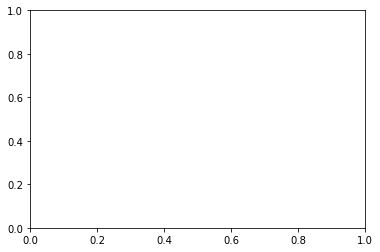

In [205]:
# plot predictions
plt.scatter(X_train, y_train)
# plt.plot(X_train, y_pred, color='red')
## works with 1 pca -- plt.plot(y_pred, c='red')
plt.show()

In [206]:
# check score
regressor.score(X_train, y_train)

0.9827657078266799

In [212]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.6043385953567396
Mean Squared Error: 1.9667771712390396
Root Mean Squared Error: 1.4024183296146124
R Squared: 0.93588466501601


In [213]:
pred_df = pd.DataFrame({'Real Values': y_test, 'Predicted Values': predictions})
pred_df.head()

,Real Values,Predicted Values
1050,-0.367472,-0.221488
697,2.797746,3.711375
1636,-0.373913,-0.342512
2655,1.524960,0.956947
2752,0.047987,0.300206


In [214]:
pred_df.shape

(762, 2)

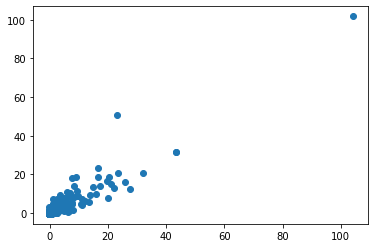

In [215]:
plt.scatter(pred_df['Real Values'], pred_df['Predicted Values'])
plt.show()